## Предобработка датасета

In [1]:

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from scipy.stats import shapiro, normaltest
from sklearn.ensemble import RandomForestRegressor
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import PowerTransformer, MinMaxScaler


In [2]:
def order_columns(df):
    """
    Функция упорядочивает столбцы,
    целевые признаки помещаются в конец датафрейма
    
    """
    
    df = df[['Количество отвердителя, м.%',
             'Содержание эпоксидных групп, %',
             'Температура вспышки, С',
             'Потребление смолы, г/м2',
             'Угол нашивки, град',
             'Шаг нашивки',
             'Плотность нашивки',
             'Плотность, кг/м3',
             'Поверхностная плотность, г/м2',
             'Модуль упругости, ГПа',
             'Соотношение матрица-наполнитель',
             'Модуль упругости при растяжении, ГПа',
             'Прочность при растяжении, МПа']]
    return df

### 1. Замена выбросов  
Воспользуемся методом межквартильного диапазона для определения выбросов, так как этот метод подходит и для ненормально распределенных значений.  Для решения задачи замены выбросов можно использовать различные методы машинного обучения, воспользуемся IterativeImputer. В этом случае мы решаем отдельную задачу машинного обучения, рассматривая пропущенный признак как целевой (y), а остальные признаки как исходные (X).

In [3]:

X_bp = pd.read_excel('../data/raw/X_bp.xlsx', index_col=0)
X_nup = pd.read_excel('../data/raw/X_nup.xlsx', index_col=0)


In [4]:
X_bp = X_bp.rename(columns={
                  'Содержание эпоксидных групп,%_2': 'Содержание эпоксидных групп, %',
                  'Температура вспышки, С_2': 'Температура вспышки, С'})

In [5]:
# Отделим первые 23 строки X_bp
X_bp_1 = X_bp.iloc[:23, :]
X_bp_2 = X_bp.iloc[23:, :]

# Отделим первые 40 строк X_nup
X_nup_1 = X_nup.iloc[:40, :]
X_nup_2 = X_nup.iloc[40:, :]

# Заменим 0 в строке 19 X_nup_1 средним по колонке
X_nup_1.loc[19, 'Шаг нашивки'] = X_nup_1['Шаг нашивки'].mean()
X_nup_1.loc[19, 'Плотность нашивки'] = X_nup_1['Плотность нашивки'].mean()


In [6]:
# Найдем выбросы в X_bp_2

Q1 = X_bp_2.quantile(0.25)
Q3 = X_bp_2.quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
outliers_bp = X_bp_2[~((X_bp_2 < lower_bound) | (X_bp_2 > upper_bound))]

# Найдем выбросы в X_nup_2

Q1 = X_nup_2.quantile(0.25)
Q3 = X_nup_2.quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
outliers_nup = X_nup_2[~((X_nup_2 < lower_bound) | (X_nup_2 > upper_bound))]

print('Количество выбросов в X_bp -', outliers_bp.isna().sum().sum())
print('Количество выбросов в X_nup -', outliers_nup.isna().sum().sum())

Количество выбросов в X_bp - 67
Количество выбросов в X_nup - 25


In [7]:
# Заменим выбросы на значения из X_bp_1 с помощью IterativeImputer

imputer_bp = IterativeImputer(estimator=RandomForestRegressor(n_estimators=10, random_state=0),
                              max_iter=10,
                              random_state=0)
X_bp_1_imputed = imputer_bp.fit_transform(X_bp_1)
outliers_imputed_bp = imputer_bp.transform(outliers_bp)
X_bp_2_imputed = X_bp_2.copy()
X_bp_2_imputed[outliers_bp.columns] = outliers_imputed_bp

# Заменим выбросы на значения из X_nup_1 с помощью IterativeImputer

imputer_nup = IterativeImputer(estimator=RandomForestRegressor(n_estimators=10, random_state=0),
                              max_iter=10,
                              random_state=0)
X_nup_1_imputed = imputer_nup.fit_transform(X_nup_1)
outliers_imputed_nup = imputer_nup.transform(outliers_nup)
X_nup_2_imputed = X_nup_2.copy()
X_nup_2_imputed[outliers_nup.columns] = outliers_imputed_nup


In [8]:
# Объединяем обратно строки

X_bp = pd.concat([X_bp_1, X_bp_2_imputed])
X_nup = pd.concat([X_nup_1, X_nup_2_imputed])


In [9]:
# Объединяем X_bp и X_nup из двух файлов

merged = X_bp.merge(X_nup, how='inner', left_index=True, right_index=True)
merged.shape


(1023, 13)

In [10]:
merged = order_columns(merged)
merged.shape

(1023, 13)

### 2. Приведение к нормальному распределению  
Постараемся привести данные к распределению Гаусса, так как модели регрессии лучше и точнее работают с нормально распределенными данными.

- #### Преобразование Бокса-Кокса  

Исключим из данных столбцы, не подходящие для данной нормализации:  
-Угол нашивки: вероятно имеет распределение Бернулли  
-Шаг нашивки, плотность нашивки: некоторые значения равны 0

In [11]:
data = merged.drop(columns=["Угол нашивки, град", "Шаг нашивки", "Плотность нашивки"])

In [12]:
# Преобразование Бокса-Кокса
pt = PowerTransformer(method='box-cox', standardize=False)
norm_data = pt.fit_transform(data)

# Датафрейм для хранения преобразованных данных
norm_data = pd.DataFrame(norm_data, columns=list(data))

In [13]:
def compare_hist(df, norm_df):
    """Функция, сравнивающая распределение до и после нормализации"""
    
    for column in df.columns:
        fig, axs = plt.subplots(1, 2, figsize=(8, 3))

        fig.suptitle(column)

        sns.histplot(df[column], bins=26, ax=axs[0], kde=True)
        axs[0].set_xlabel('Исходное распределение')

        sns.histplot(norm_df[column], bins=26, ax=axs[1], kde=True)
        axs[1].set_xlabel('Распределение после нормализации')
        
        plt.show()

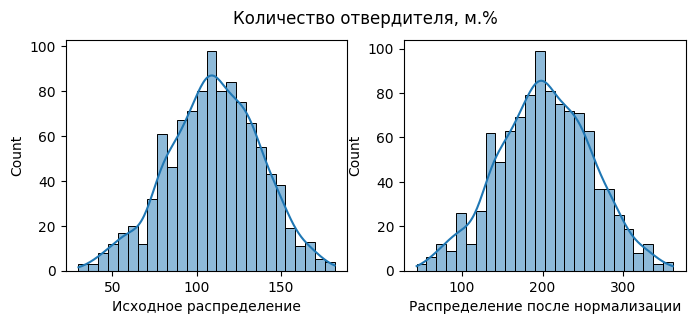

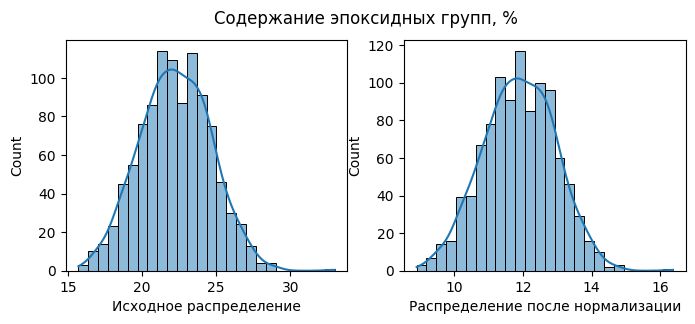

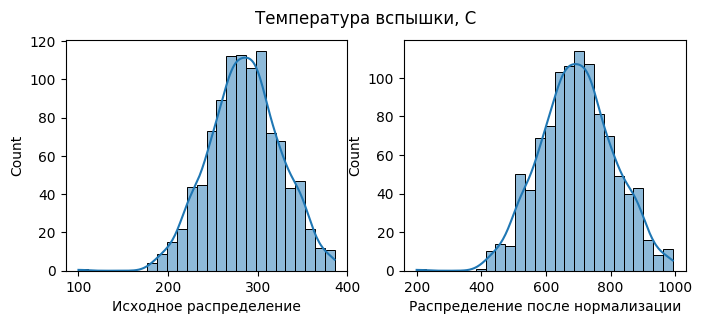

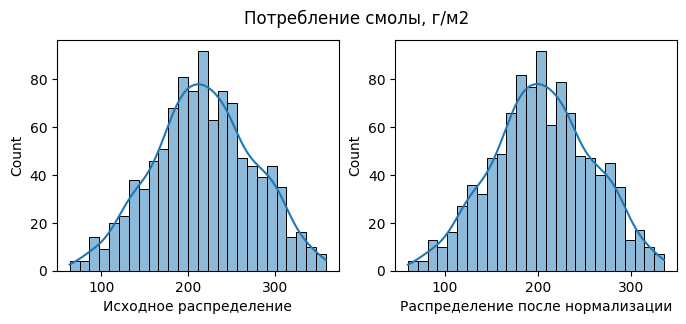

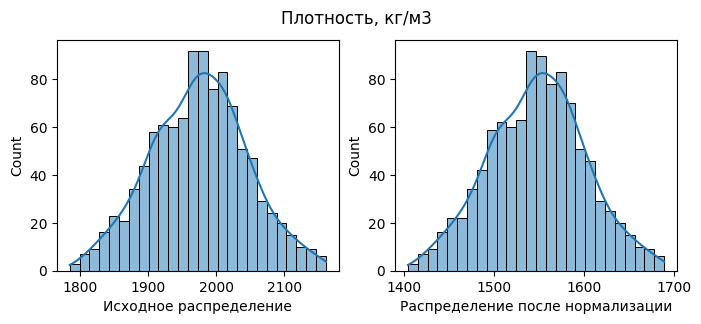

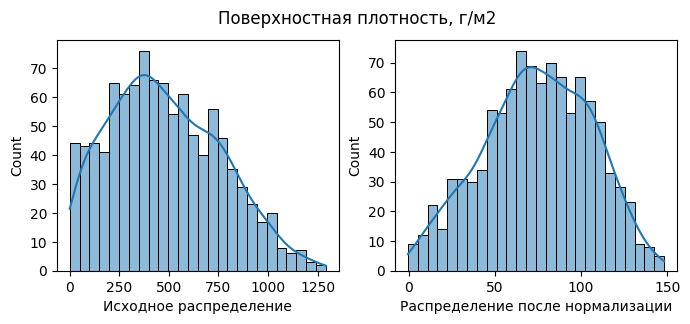

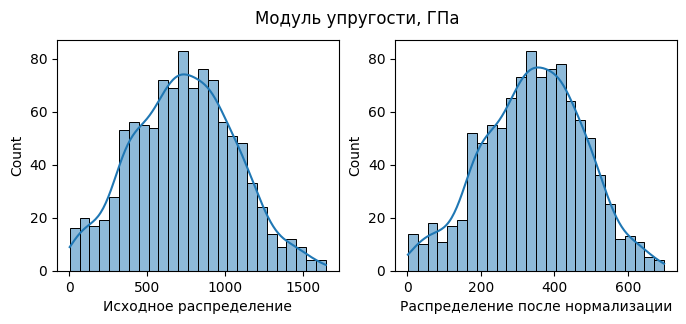

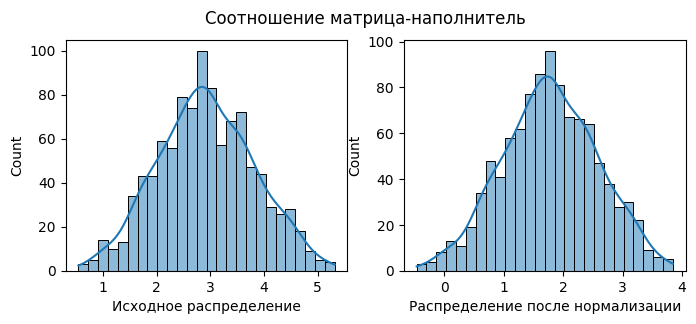

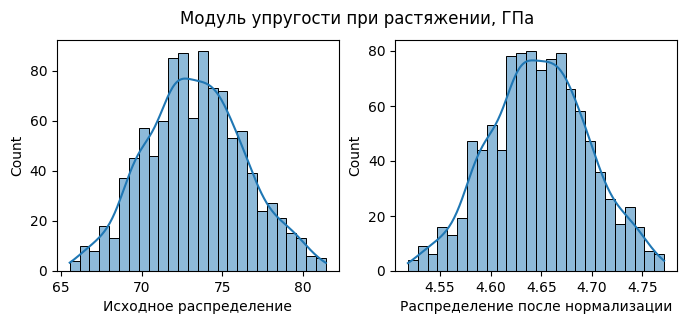

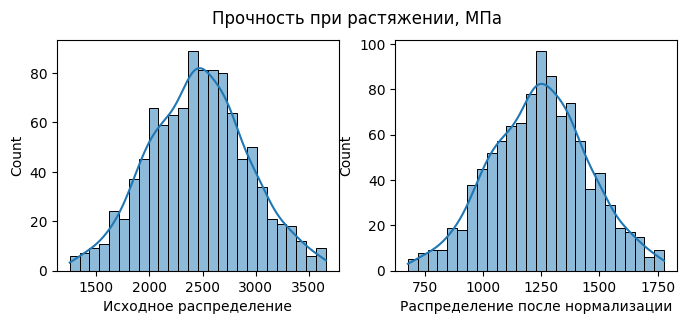

In [14]:
# Гистограммы распределения исходных и преобразованных данных
compare_hist(data, norm_data)

- #### Возведение в степень  

Для нормализации параметров Шаг нашивки и Плотность нашивки используем квадратный корень

In [15]:
sqrt_cols = merged[["Шаг нашивки", "Плотность нашивки"]] ** 1/2

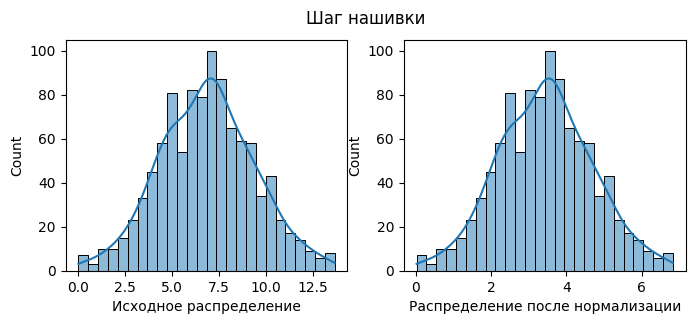

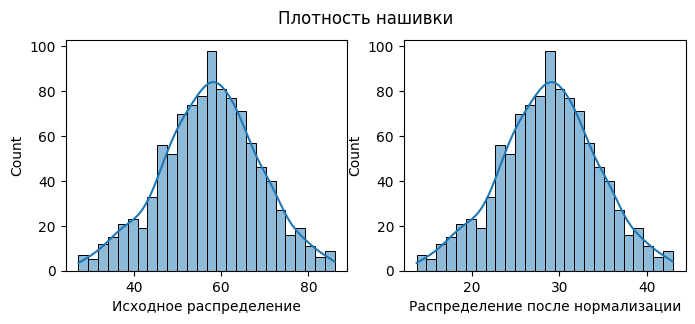

In [16]:
compare_hist(merged[["Шаг нашивки", "Плотность нашивки"]], sqrt_cols)

Визуально форма распределения не изменилась после возведения в степень 1/2. Поэтому для колонок "Шаг нашивки" и "Плотность нашивки" нормализацию применять не будем.

- #### Проверка на нормальность после нормализации

In [17]:
# собираем нормализованный датасет
data = norm_data.merge(
                       merged[["Угол нашивки, град", "Шаг нашивки", "Плотность нашивки"]],
                       left_index=True,
                       right_index=True
                       )

In [18]:
# упорядочить столбцы
data = order_columns(data)

In [19]:
# Тесты на нормальность

result_df = pd.DataFrame(columns=['pearson p-value', 'shapiro p-value'])

for column in data.columns:
    # тест по Пирсону
    _, pearson_p_value = normaltest(data[column])
    
    # тест по Шапиро-Уилку
    _, shapiro_p_value = shapiro(data[column])
    
    # записываем p-value в таблицу
    result_df.loc[column] = [round(pearson_p_value, 6), round(shapiro_p_value, 6)]

result_df

,pearson p-value,shapiro p-value
"Количество отвердителя, м.%",0.240982,0.205793
"Содержание эпоксидных групп, %",0.903651,0.162538
"Температура вспышки, С",0.958786,0.033237
"Потребление смолы, г/м2",0.006395,0.005947
"Угол нашивки, град",0.000000,0.000000
Шаг нашивки,0.639678,0.231902
Плотность нашивки,0.334179,0.029332
"Плотность, кг/м3",0.302668,0.100310
"Поверхностная плотность, г/м2",0.000000,0.000004
"Модуль упругости, ГПа",0.027236,0.004393


Таким образом, распределение параметров "Поверхностная плотность" и "Потребление смолы" так и не удалось привести к нормальному распределению после преобразования.

### 3. Масштабирование данных  
Метод MinMaxScaler, масштабирующий данные в интервале (0,1)

In [20]:
scl = MinMaxScaler()
data_scl = pd.DataFrame(scl.fit_transform(data), columns = data.columns)
data_scl.sample(5)

,"Количество отвердителя, м.%","Содержание эпоксидных групп, %","Температура вспышки, С","Потребление смолы, г/м2","Угол нашивки, град",Шаг нашивки,Плотность нашивки,"Плотность, кг/м3","Поверхностная плотность, г/м2","Модуль упругости, ГПа",Соотношение матрица-наполнитель,"Модуль упругости при растяжении, ГПа","Прочность при растяжении, МПа"
724,0.301861,0.394474,0.360520,0.470533,1.0,0.444269,0.898181,0.422721,0.643157,0.650724,0.810635,0.389133,0.945952
878,0.739202,0.265552,0.826618,0.327332,1.0,0.674945,0.325952,0.747777,0.655834,0.141028,0.723581,0.550426,0.219810
300,0.490752,0.349128,0.403905,0.427614,0.0,0.637578,0.272955,0.463425,0.545588,0.446541,0.460780,0.703941,0.220417
852,0.776579,0.519900,0.664989,0.579654,1.0,0.443348,0.366792,0.625688,0.197394,0.206079,0.339347,0.634628,0.306754
721,0.498672,0.394179,0.619789,0.273525,1.0,0.567799,0.677098,0.601389,0.601504,0.555045,0.313951,0.480286,0.596910


In [21]:
data_scl.shape

(1023, 13)

### 4. Сохранение  
Сохраним очищенные от выбросов данные в файл.

In [22]:
merged.to_csv('../data/clean_save_outliers_in_real_data.csv', index=False)

Сохраним очищенные от выбросов, нормализованные и отмасштабированные данные в файл.

In [23]:
data_scl.to_csv('../data/processed_save_outliers_in_real_data.csv', index=False)

### [Далее](https://github.com/Svkhorol/Diploma-Project-Bauman-MSTU/blob/main/notebooks/4_Modeling.ipynb)  
### [К содержанию](https://github.com/Svkhorol/Diploma-Project-Bauman-MSTU/blob/main/README.md)